In [36]:
import pandas as pd 
import numpy as np 
import os
import glob
import subprocess
from tqdm import tqdm
import itertools
import networkx as nx
import seaborn as sns
import matplotlib as mpl
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import math
import re
from utils import * 
from src.data import * 
import json
import sklearn
import io 

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
def load_align(path:str):
    cols = ['query', 'target', 'evalue', 'pident', 'bits', 'qseq', 'tseq', 'alnlen', 'qstart', 'qend', 'tstart', 'tend']
    align_df = pd.read_csv(path, sep='\t', header=None, names=cols)
    align_df = align_df[align_df.bits > 50].copy()
    align_df['start_offset'] = np.abs(align_df.qstart - align_df.tstart)
    align_df['alignment_id'] = [' - '.join(sorted([row.target, row.query])) for row in align_df.itertuples()]
    align_df = align_df[align_df['query'] != align_df['target']].copy() # Drop self-alignments.
    align_df = align_df.sort_values('bits').drop_duplicates('alignment_id') # Drop duplicate alignments.
    return align_df

In [38]:
# NOTE: I modified some of the plasmid file names for consistency with the metadata, e.g. pTiS4 to S4_ti
# TODO: What is the Atu or Avi prefix? Should I not have changed those?

metadata_df = load_weisberg_2020_metadata()

In [39]:
for path in glob.glob('../data/data-1/ncbi/genbank/*'):
    fasta_path = os.path.basename(path).replace('.gbk', '.fn')
    fasta_path = os.path.join('../data/data-1/ncbi/fasta/', fasta_path)
    if not os.path.exists(fasta_path):
        print(f'Writing FASTA nucleotide file to {fasta_path}')
        file = GBKFile(path)
        file.to_fasta(fmt='nt', path=fasta_path)

# Created HMM library by concatenating individual HMM filed into library.hmm.
# Had to manually-remove a string containing "ELEMENTS OF EXTERNAL ORIGIN;" because it caused issues with parsing. 
for path in tqdm(glob.glob('../data/data-1/ncbi/fasta/*'), 'Running HMMs on plasmids...'):
    source_id = os.path.basename(path).replace('.fn', '')
    output_path = f'../data/data-1/hmmer/{source_id}.tsv'
    if not os.path.exists(output_path):
        subprocess.run(f'nhmmer -E 10 --tblout {output_path} ../data/data-1/hmms/library.hmm {path}', shell=True, check=True, stdout=subprocess.DEVNULL)

Running HMMs on plasmids...: 100%|██████████| 142/142 [00:00<00:00, 217846.07it/s]


load_hmmer: Num. hits for query T-DNA_left_border: 296
load_hmmer: Num. hits for query T-DNA_right_border: 426
load_hmmer: Num. hits for query overdrive: 43
2
3


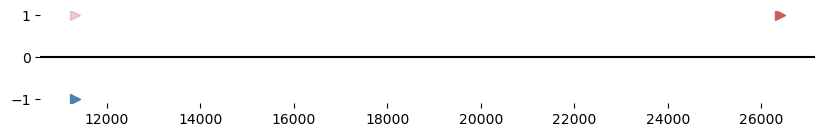

In [40]:
# right_border_counts = borders_df[borders_df.annotation.str.contains('right_border')].source_id.value_counts()
# left_border_counts = borders_df[borders_df.annotation.str.contains('left_border')].source_id.value_counts()
# right_border_counts = right_border_counts[right_border_counts > 3]
# right_border_counts
# left_border_counts

def filter_right_borders(target_df:pd.DataFrame):

    get_next = lambda i : 'none' if (i == (len(target_df) - 1)) else target_df.iloc[i + 1].annotation
    get_previous = lambda i : 'none' if (i == 0) else target_df.iloc[i - 1].annotation
    
    target_df = target_df.sort_values('start')
    target_df['previous_annotation'] = [get_previous(i) for i in range(len(target_df))]
    target_df['next_annotation'] = [get_next(i) for i in range(len(target_df))]

    mask = (target_df.annotation.str.contains('right_border'))
    mask = mask & target_df.next_annotation.str.contains('none|left_border')
    mask = mask & target_df.previous_annotation.str.contains('none|left_border')
    return target_df[mask].copy()

def plot_borders(target_df:pd.DataFrame):

    fig, ax = plt.subplots(figsize=(10, 1.2))
    target_length = target_df.length.iloc[0]

    palette = {'T-DNA_right_border':'indianred', 'T-DNA_left_border':'steelblue'}
    y = {'T-DNA_right_border':1, 'T-DNA_left_border':-1}

    target_df = target_df[target_df.annotation.isin(y)].copy()
    resolved_target_df = resolve_borders(target_df, filter_=False)
    print(len(resolved_target_df))
    print(len(target_df))

    ax.axhline(xmin=0, xmax=target_length, color='black')

    def plot(df, alpha=1):
        for annotation, df_ in df.groupby('annotation'):
            for row in df_.itertuples():
                dx = row.stop - row.start if (row.strand == '+') else -row.stop - row.start
                x = row.start if (row.strand == '+') else row.stop 
                marker = '>' if (row.strand == '+') else '<'
                ax.scatter([x], [y[annotation]],color=palette[annotation], s=50, marker=marker, alpha=alpha)

    plot(target_df, alpha=0.3)
    plot(resolved_target_df, alpha=1)
    # ax.set_visible(False)
    for _, spine in ax.spines.items():
        spine.set_visible(False)

hmmer_df = load_hmmer_files(hmmer_dir='../data/data-1/hmmer')
# plot_borders(hmmer_df[hmmer_df.target_name == 'JL5166_16'])
# plot_borders(hmmer_df[hmmer_df.target_name == 'AS1D6_11']) 
plot_borders(hmmer_df[hmmer_df.target_name == 'NC_002575']) 

# For the purposes of detecting potential motifs, require that every valid right border have a corresponding left border

In [41]:
hmmer_df = load_hmmer_files(hmmer_dir='../data/data-1/hmmer')
overdrive_df = build_overdrive_dataset(overwrite=True, fasta_dir='../data/data-1/ncbi/fasta/', hmmer_df=hmmer_df, length=100, data_dir='../data/data-1/')

if 'plasmid_type' not in overdrive_df.columns:
    index = overdrive_df.index
    overdrive_df = overdrive_df.merge(metadata_df, left_on='source_id', right_on='source_id', how='left')
    overdrive_df.index = index # Make sure to restore the index after the merge. 

overdrive_df.to_csv('../data/data-1/overdrive.csv')
FASTAFile(df=overdrive_df).write('../data/data-1/overdrive.fn')

virc1_df = build_virc_dataset(overwrite=False, product='VirC1')
virc2_df = build_virc_dataset(overwrite=False, product='VirC2')

# Identified a handful of cases of detected overdrive variants which seem to multiple (4+) GTGCATCC repeats. I ran a BLASTn search, 
# and found other similar repeat regions in non-Agro bacteria, which suggests to me that this might be some kind of weird recombination
# event or replication slippage. I am going to exclude them from the dataset for now, as they are interfering with motif search. 

is_weird_repeat = lambda seq : re.search(r'(GTGCATCC|GTGCCTTC|TGTTCAAT|AGTTCATT){3,}', seq) is not None 
print(f'Removing {overdrive_df.seq.apply(is_weird_repeat).sum()} adjacent regions with repeats from the dataset.')
overdrive_df = overdrive_df[~overdrive_df.seq.apply(is_weird_repeat)]

# right_border_false_positive_ids = ['JL5166_16:42807-43007', 'JL5166_18:12337-12537', 'JL5166_18:64464-64664', 'AS2E5_10:145466-145666']
# overdrive_df = overdrive_df[~overdrive_df.index.isin(right_border_false_positive_ids)]

overdrive_df.to_csv('../data/data-1/overdrive.csv')
FASTAFile(df=overdrive_df).write('../data/data-1/overdrive.fn')
FASTAFile(df=overdrive_df.drop_duplicates('left_of_right_border_seq').drop(columns=['seq']).rename(columns={'left_of_right_border_seq':'seq'})).write('../data/data-1/left_of_right_border.fn')


load_hmmer: Num. hits for query T-DNA_left_border: 296
load_hmmer: Num. hits for query T-DNA_right_border: 426
load_hmmer: Num. hits for query overdrive: 43
build_overdrive_dataset: Found 193 right borders.
build_overdrive_dataset: Found 142 FASTA files.
Removing 10 adjacent regions with repeats from the dataset.


In [42]:
overdrive_df.left_of_right_border_seq.nunique()
# overdrive_df.seq.nunique()

# for row in overdrive_df.itertuples():
#     assert row.right_border_seq not in row.left_of_right_border_seq

# overdrive_df[[col for col in overdrive_df.columns if ('start' in col) or ('stop' in col)] + ['strand']]

28

In [43]:
def check_overdrive_dataset(overdrive_df:pd.DataFrame):
    '''Check the raw files to make sure I actually grabbed overdrives that exist in the FASTA.'''
    for row in tqdm(list(overdrive_df.itertuples()), desc='check_overdrive_dataset'):
        path = os.path.join(data_dir, f'ncbi/fasta/{row.source_id}.fn')
        with open(path, 'r') as f:
            content = f.read().replace('\n', '')
        seq = re.sub(r'\s+', '', row.seq)
        if (row.strand == '-'):
            seq = str(Seq(seq).reverse_complement())
        assert re.search(seq, content) is not None, f'Overdrive sequence not found in {path}.'

def check_virc1_dataset(virc1_df:pd.DataFrame):
    '''Check the raw files to make sure I grabbed a VirC1 from all annotations which have them.'''

    for path in tqdm(glob.glob('../data/data-1/ncbi/genbank/*'), desc='check_virc1_dataset'):
        source_id = os.path.basename(path).replace('.gbk', '')
        with open(path, 'r') as f:
            content = f.read().replace('\n', '')
        
        if re.search(r'[vV]ir[cC]1', content) is not None:
            # print(source_id)
            assert source_id in virc1_df.source_id.values, f'VirC1 sequence in {path} is not present in the dataset.'

check_overdrive_dataset(overdrive_df)
# check_virc1_dataset(virc1_df)

# TODO: Also check to make sure there is only one VirC1 and VirC2 per plasmid. 

check_overdrive_dataset: 100%|██████████| 183/183 [00:00<00:00, 2757.71it/s]


In [44]:
virc2_df['n_beta_sheet'] = [seq[82:128] for seq in virc2_df.seq]
virc2_df['c_beta_sheet'] = [seq[150:200] for seq in virc2_df.seq]
virc2_df['rhh_seq'] = [row.n_beta_sheet + row.c_beta_sheet for row in virc2_df.itertuples()]

In [45]:
# There is tons of redundancy in the dataset... 
print('Num. overdrive variants:', overdrive_df.seq.nunique())
print('Num. VirC1 variants:', virc1_df.seq.nunique())
print('Num. VirC2 variants:', virc2_df.rhh_seq.nunique())

overdrive_variants = {seq:i for i, seq in enumerate(overdrive_df.seq.unique())}
virc1_variants = {seq:i for i, seq in enumerate(virc1_df.seq.unique())}
# virc2_variants = {seq:i for i, seq in enumerate(virc2_df.seq.unique())}
virc2_variants = {seq:i for i, seq in enumerate(virc2_df.rhh_seq.unique())}

overdrive_df['variant'] = overdrive_df.seq.map(overdrive_variants)
virc1_df['variant'] = virc1_df.seq.map(virc1_variants)
virc2_df['variant'] = virc2_df.rhh_seq.map(virc2_variants)

overdrive_df['virc1_seq'] = overdrive_df.source_id.map(virc1_df.set_index('source_id').seq)
overdrive_df['virc2_seq'] = overdrive_df.source_id.map(virc2_df.set_index('source_id').seq)
overdrive_df['virc2_rhh_seq'] = overdrive_df.source_id.map(virc2_df.set_index('source_id').rhh_seq)
overdrive_df['virc1_variant'] = overdrive_df.virc1_seq.map(virc1_variants)
overdrive_df['virc2_variant'] = overdrive_df.virc2_rhh_seq.map(virc2_variants)
overdrive_df.to_csv('../data/data-1/overdrive.csv')

Num. overdrive variants: 27
Num. VirC1 variants: 13
Num. VirC2 variants: 14


In [46]:
# Are there any overdrive sequences which are missing corresponding VirC12 proteins?
print('Num. overdrive sequences without annotated VirC1:', overdrive_df.virc1_seq.isnull().sum())
for row in overdrive_df[overdrive_df.virc1_seq.isnull()].itertuples():
    print(row.source_id) # Looking at the GenBank files, it seems as though these plamids are just missing part of the vir operon. 

Num. overdrive sequences without annotated VirC1: 3
NCPPB_3554_ti
Y2_73_ti
Y2_73_ti


In [47]:
cmap = mpl.colormaps.get_cmap('tab20c')
cmap = cmap.resampled(overdrive_df.plasmid_type.nunique())
palette = {f:cmap(i) for i, f in enumerate(overdrive_df.sort_values('plasmid_class').plasmid_type.unique())} # Map each category to a color. 


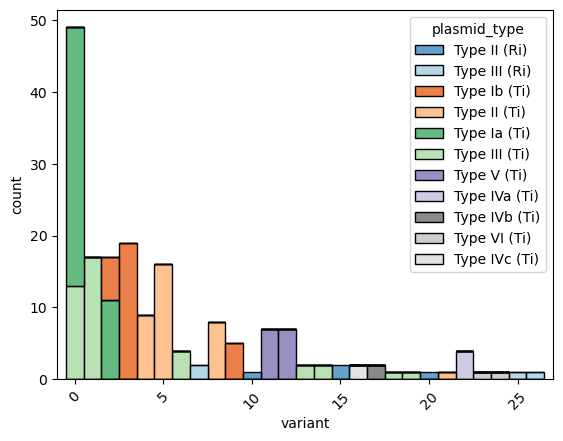

In [48]:
def figure(overdrive_df:pd.DataFrame, palette:dict=palette):

    figure_df = overdrive_df.copy()
    figure_df = figure_df.sort_values('plasmid_class')

    fig, ax = plt.subplots()

    sns.histplot(data=figure_df, ax=ax, x='variant', hue='plasmid_type', legend=True, multiple='stack', palette=palette, discrete=True)
    # sns.histplot(data=figure_df, ax=ax, x='plasmid_type', hue='variant', legend=False, multiple='stack', palette='tab20c')

    ax.set_ylabel('count')
    ax.set_xticks(ax.get_xticks(), labels=ax.get_xticklabels(), rotation=45)
    ax.set_xlim(xmin=-1, xmax=27)
    plt.show()

figure(overdrive_df)


KeyError: "['type_ivc_var17', 'type_ivb_var18', 'type_iii_var15', 'type_ii_var9', 'type_ib_var10', 'type_ii_var16'] not in index"

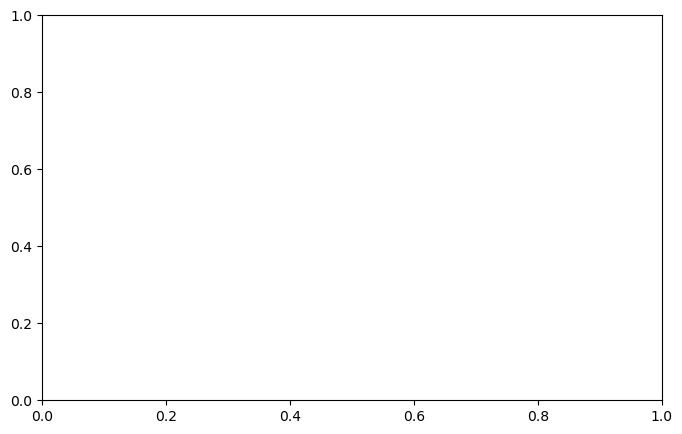

In [49]:
# We can see that identical upstream regions are generally limited to plasmids of the same type, with the exception
# of some which are found in both Type 1a and Type 1b plasmids, as well as Type 1a and Type III. 

# Would be useful to look at how exactly these regions compare. Because most of the overdrive variants correspond to a single
# plasmid type, it is probably OK to drop (variant, plasmid_type) duplicates. 

def figure(overdrive_df, palette=palette):

    get_id = lambda row : row.plasmid_type.split('(')[0].strip().lower().replace(' ', '_') + f'_var{row.variant}'

    figure_df = overdrive_df.copy()
    figure_df = figure_df.sort_values('plasmid_class')
    figure_df = figure_df.drop_duplicates(['variant', 'plasmid_type'])
    figure_df['id'] = [get_id(row) for row in figure_df.itertuples()]
    FASTAFile(df=figure_df.set_index('id')).write('../data/data-1/figure_2.fn')
    figure_df = figure_df.set_index('id')

    align_df = load_align('../data/data-1/figure_2_align.tsv')
    
    graph = get_alignment_graph(align_df, order=figure_df.index.values)
    alignment_groups = nx.connected_components(graph)

    fig, ax = plt.subplots(figsize=(8, 5))

    pos = get_layout(graph)

    colors = get_graph_colors(graph, figure_df, field='plasmid_type', palette=palette)
    nx.draw_networkx_edges(graph, ax=ax, pos=pos, edge_color='lightgray', width=0.5)
    nx.draw_networkx_nodes(graph, ax=ax, node_size=50, pos=pos, edgecolors='black', node_color=colors, linewidths=0.5)

    legend_labels = figure_df.plasmid_type.unique()
    legend_handles = [mpl.lines.Line2D([None], [None], ls='none', markersize=5, marker='o', markeredgewidth=0.5, markeredgecolor='black', markerfacecolor=palette.get(label)) for label in legend_labels]
    ax.legend(legend_handles, legend_labels, fontsize='small', bbox_to_anchor=(1.05, 1.05))

    for _, spine in ax.spines.items():
        spine.set_visible(False)

    plt.show()

    return align_df, alignment_groups

align_df, alignment_groups = figure(overdrive_df)

In [ ]:
# for group, df in overdrive_df.groupby('group'):
#     if ('Ri' in df.plasmid_type) and ('Ti' in df.plasmid_type):
#         print(f'Group {group} contains both Ti and Ri plasmids.')

In [ ]:
# # It seems like locating some kind of common motif is essential for further analysis, based on uncertainty regarding the presence
# # and/or starting location of the overdrive sequence. Preliminary analysis shows that an exact match for the consensus sequence
# # identified by Shurvinton and Ream  (1991) is only present in ~40 of the plasmids. I decided to try a motif search with
# # the MEME software suite.
# # 
# # Worth noting that I used the OOPS (one occurrence per sequence) assumption, although not every sequence has an occurrence of the motif. 
# # Not sure if running with a different assumption (e.g. ZOOPS) would change the results, or if this was the best choice considering that
# # there is not one occurrence per sequence. 

# # meme overdrive_ti.fna -dna -oc . -nostatus -time 14400 -mod oops -nmotifs 3 -minw 5 -maxw 8 -objfun classic -markov_order 0

# # The MAST output file contains the identified motifs in each sequence. 
# overdrive_mast_df = read_csv_chunk('../data/data-1/overdrive_ti_mast.txt', names=['id', 'e_value', 'motif_diagram'])
# overdrive_mast_df['strain_id'] = overdrive_mast_df['id'].str.replace(r'_\d+-\d+', '', regex=True)
# overdrive_mast_df['source_id'] = [f'{strain_id}_ti' for strain_id in overdrive_mast_df['strain_id']]
# for i in [1, 2, 3]:
#     overdrive_mast_df[f'has_motif_{i}'] = overdrive_mast_df.motif_diagram.str.contains(f'{i}]', regex=False)
#     overdrive_df[f'has_motif_{i}'] = overdrive_df.index.map(overdrive_mast_df[f'has_motif_{i}'])

# overdrive_ti_df = overdrive_df[overdrive_df.plasmid_class == 'Ti']
# print('Num. Ti plasmids:', overdrive_ti_df.source_id.nunique(), end='\n\n')

# for i in [1, 2, 3]:
#     n = overdrive_mast_df.groupby('source_id').apply(lambda df : np.any(df[f'has_motif_{i}']), include_groups=False).sum()
#     print(f'Num. Ti plasmids with motif {i}:', n)

# overdrive_motif_1_df = read_csv_chunk('../data/data-1/overdrive_ti_meme.txt', names=['id', 'start', 'p_value', 'site_1', 'site_2', 'site_3'], start_line=296, end_line=694)
# motif_1 = overdrive_motif_1_df.site_2.iloc[0]
# overdrive_motif_1_df.sort_values('p_value', ascending=False)

# with open('../data/data-1/overdrive_ti_motif_1.fna', 'w') as f:
#     content = ''
#     for row in overdrive_motif_1_df.itertuples():
#         content += f'>{getattr(row, 'id')}\n'

#         seq = f'{row.site_1}{row.site_2}{row.site_3}'.replace('.', '')
#         content += f'{seq}\n'
#     f.write(content)

# # The motif seems to be the same as that identified by Shurvinton and Ream. It (or a variation) is identified at least once in every Ti plasmid
# # It is unclear if the region to the left or right of the consensus is important for overdrive functionality. Notably, some of the identified motifs
# # are immediately adjacent to the right border, which seems to imply that the left region is not universally important. 
# print('\nMotif 1:', motif_1, f'({overdrive_motif_1_df.site_2.nunique()} variants)')


In [ ]:
# How to go about the mutual information analysis:
# (1) Look at the alignment groups of the RB upstream sequences and try to generate an MSA. 
# (2) Align the VirC2 from the corresponding assemblies. 

# There are multiple overdrive sequences and VirC1s in certain strains, so might want to consider every possible pair. 

# TODO: I don't think there are enough sequences to do reliable mutual information analysis (< 100 sequences in every alignment group).
# Might need to look in the NCBI database for more sequences. 

# def build_paired_msa(alignment_group:int=5, virc_dataset_df:pd.DataFrame=virc_dataset_df, overdrive_df:pd.DataFrame=overdrive_df, data_dir:str='../data/msa'):
    
#     msa_df = list()

#     overdrive_df = overdrive_df[overdrive_df.alignment_group == alignment_group].copy()
#     virc_dataset_df = virc_dataset_df[virc_dataset_df['product'].str.contains('virc1', case=False)].copy()

#     strain_ids = overdrive_df.strain_id.unique()
#     for strain_id in strain_ids:
#         od_seqs = overdrive_df[overdrive_df.strain_id == strain_id].seq.values 
#         virc1_seqs = virc_dataset_df[virc_dataset_df.strain_id == strain_id].seq.values 
#         for od_seq, virc1_seq in itertools.product(od_seqs, virc1_seqs):
#             msa_df.append({'virc1_seq':virc1_seq, 'od_seq':od_seq, 'strain_id':strain_id})

#     msa_df = pd.DataFrame(msa_df) # DataFrame contains rows of interaction pairs. 
#     msa_df.index = msa_df.index.astype(str)

#     FASTAFile(df=msa_df.rename(columns={'od_seq':'seq'})).write(f'{data_dir}/od_{alignment_group}.fna')
#     FASTAFile(df=msa_df.rename(columns={'virc1_seq':'seq'})).write(f'{data_dir}/virc1_{alignment_group}.fa')

#     cmd = '/home/prichter/muscle5.1.linux_intel64'
#     if not os.path.exists(f'{data_dir}/od_{alignment_group}.afn'):
#         subprocess.run(f'{cmd} -align {data_dir}/od_{alignment_group}.fna -output {data_dir}/od_{alignment_group}.afn', shell=True, check=True, stdout=subprocess.DEVNULL)
#     if not os.path.exists(f'{data_dir}/virc1_{alignment_group}.afa'):
#         subprocess.run(f'{cmd} -align {data_dir}/virc1_{alignment_group}.fa -output {data_dir}/virc1_{alignment_group}.afa', shell=True, check=True, stdout=subprocess.DEVNULL)

#     paired_msa_df = FASTAFile(path=f'{data_dir}/od_{alignment_group}.afn').to_df().rename(columns={'seq':'seq_a'})
#     paired_msa_df = pd.concat([paired_msa_df, FASTAFile(path=f'{data_dir}/virc1_{alignment_group}.afa').to_df().rename(columns={'seq':'seq_b'})], axis=1)
#     paired_msa_df = paired_msa_df.drop(columns=['description'])
#     return paired_msa_df


# paired_msa_df = build_paired_msa()

In [ ]:
# has_rb_and_od = lambda df : np.any(df.query_name.str.contains('right_border')) or np.any(df.query_name.str.contains('overdrive'))

# def get_hmmer_overdrive_info():
#     hmmer_df = pd.concat([HMMerFile(path).to_df() for path in glob.glob('../data/hmmer/*')])
#     hmmer_df['length'] = np.where(hmmer_df.strand == '+', hmmer_df.target_to - hmmer_df.target_from, hmmer_df.target_from - hmmer_df.target_to)
#     hmmer_df['length'] = hmmer_df.length + 1 # Add one for the indexing. 

#     df = list()
#     for contig_id, hmmer_df_ in hmmer_df.groupby('target_name'): # Group by hits which are on the same contig. 
#         # Going to want to filter out all of the distances which are outliers, these will be due to the fact that there might be multiple
#         # overdrive sequences and RBs in a single plasmid. 
#         rb_rows = list(hmmer_df_[hmmer_df_.query_name.str.contains('right_border')].itertuples()) # Overdrive sequences are adjacent to the right border. 
#         od_rows =  list(hmmer_df_[hmmer_df_.query_name.str.contains('overdrive')].itertuples())

#         for rb_row, od_row in itertools.product(rb_rows, od_rows):
#             if rb_row.strand != od_row.strand:
#                 continue # Must be on the same strand. 
#             if (rb_row.strand == '+'):
#                 d = od_row.target_from - rb_row.target_to
#             elif (rb_row.strand == '-'):
#                 d = rb_row.target_to - od_row.target_from
#             df.append({'contig_id':contig_id, 'dist_from_rb':d, 'strand':rb_row.strand, 'od_length':od_row.length}) 
    
#     df = pd.DataFrame(df)
#     df = df[(df.dist_from_rb > 0)].copy() # Remove anything negative, which I don't think should happen. 
#     df = df.sort_values('dist_from_rb').drop_duplicates('contig_id', keep='first') # Pick the sequence with the smallest separation on each contig. 
#     return df

# get_hmmer_overdrive_info()

In [ ]:
# The upstream regions are too highly-conserved amongst the alignment groups to do reasonable analysis with mutual information. 
# Most of the positions have zero entropy (i.e. contain no usable information) because they are all identical. Also, the alignment
# groups are far too small. 

# Because there is uncertainty about where the overdrive sequence might start, it doesn't makes sense to use the entire
# upstream region. You'd basically be asking "which positions in the upstream region are associated with which residues in VirC, and 
# if we think the location of the overdrive sequence is not conserved, this won't be interpretable. 

# fig, ax = plt.subplots()

# cmap = mpl.colormaps.get_cmap('tab20c')
# cmap = cmap.resampled(3)
# # palette = [cmap(i) for i in np.linspace(0, 1, metadata_df[field].dropna().nunique())] # Get colors for the palette.
# palette = {biovar:cmap(i) for i, biovar in enumerate(['BV1', 'BV2', 'BV3'])} # Map each category to a color. 

# figure_df = metadata_df[metadata_df.biovar.isin(['BV1', 'BV2', 'BV3'])].copy()
# figure_df = figure_df[figure_df.plasmid_class == 'Ti'].copy()
# sns.histplot(figure_df, x='plasmid_type', hue='biovar', multiple='dodge', palette=palette, ax=ax)
# ax.set_xticks(np.arange(len(ax.get_xticklabels())), labels=ax.get_xticklabels(), rotation=45)
# plt.show()


In [ ]:
# # ! mmseqs easy-cluster ../data/virc1.fa ../data/mmseqs/virc1 ../data/mmseqs/tmp/ --min-seq-id 0.99
# virc1_cluster_df = pd.read_csv('../data/mmseqs/virc1_cluster.tsv', sep='\t', header=None, names=['cluster_rep', 'id'])
# virc1_cluster_df['cluster_id'] = virc1_cluster_df.cluster_rep.map({id_:f'virc1_group_{i}' for i, id_ in enumerate(virc1_cluster_df.cluster_rep.unique())})
# print('Num. VirC1 clusters:', virc1_cluster_df.cluster_rep.nunique())

# overdrive_df['virc1_cluster_id'] = overdrive_df.index.map(virc1_cluster_df.set_index('id').cluster_id)
# overdrive_df['virc1_cluster_id'] = overdrive_df.virc1_cluster_id.fillna('none')

# # ! mmseqs easy-cluster ../data/virc2.fa ../data/mmseqs/virc2 ../data/mmseqs/tmp/ --min-seq-id 0.99
# virc2_cluster_df = pd.read_csv('../data/mmseqs/virc2_cluster.tsv', sep='\t', header=None, names=['cluster_rep', 'id'])
# virc2_cluster_df['cluster_id'] = virc2_cluster_df.cluster_rep.map({id_:f'virc2_group_{i}' for i, id_ in enumerate(virc2_cluster_df.cluster_rep.unique())})
# print('Num. VirC2 clusters:', virc2_cluster_df.cluster_rep.nunique())

# overdrive_df['virc2_cluster_id'] = overdrive_df.index.map(virc2_cluster_df.set_index('id').cluster_id)
# overdrive_df['virc2_cluster_id'] = overdrive_df.virc2_cluster_id.fillna('none')

In [ ]:
# def get_overlapping_right_borders(hmmer_df:pd.DataFrame):
#     right_border_df = hmmer_df[hmmer_df.annotation.str.contains('right_border')].copy()
    
#     for row in right_border_df.itertuples():
#         is_overlapping = lambda start, stop : not ((row.start > stop) or (row.stop < start))
#         get_separation = lambda start, stop :  (start - row.stop) if ((start - row.stop) > 0) else (row.start - stop)

#         # Get all right border hits which overlap with the HMM hit in row. Should be at least one. 
#         df_ = right_border_df[right_border_df.target_name == row.target_name].copy() # Filter for hits on the same sequence. 
#         df_['overlapping'] = [is_overlapping(row_.start, row_.stop) for row_ in df_.itertuples()]
#         df_['separation'] = np.where(df_.overlapping, 0, [get_separation(row_.start, row_.stop) for row_ in df_.itertuples()])
        
#         assert df_.overlapping.sum() == 1, 'get_overlapping_right_borders: There should be exactly one overlapping HMM hit.'
#         df_ = df_[~df_.overlapping].copy()
#         if len(df_) > 1:
#             print(df_.separation.values.tolist())

In [ ]:
# def figure(overdrive_df, align_df, palette:dict=palette):

#     get_id = lambda row : row.plasmid_type.split('(')[0].strip().lower().replace(' ', '_') + f'_var{row.variant}'
    
#     overdrive_df = overdrive_df.copy()
#     overdrive_df = overdrive_df.sort_values('plasmid_class')
#     overdrive_df = overdrive_df.drop_duplicates(['variant', 'plasmid_type'])
#     overdrive_df['id'] = [get_id(row) for row in overdrive_df.itertuples()]
#     overdrive_df = overdrive_df.set_index('id')

#     figure_df = align_df.copy()
#     figure_df['target_plasmid_type'] = align_df['target'].map(overdrive_df.plasmid_type)
#     figure_df['query_plasmid_type'] = align_df['query'].map(overdrive_df.plasmid_type)
#     figure_df['start_offset'] = np.abs(figure_df.qstart - figure_df.tstart)
#     figure_df = figure_df[figure_df.start_offset > 0].copy()

#     fig, (ax_a, ax_b) = plt.subplots(ncols=2, figsize=(10, 5))

#     ax_df = figure_df.copy()
#     ax_df[ax_df.target_plasmid_type != ax_df.query_plasmid_type][['target_plasmid_type', 'query_plasmid_type', 'qstart', 'tstart', 'qend', 'tend']]
#     ax_df['alignment_type'] = [' - '.join(sorted([row.query_plasmid_type, row.target_plasmid_type])) for row in ax_df.itertuples()]
#     print(ax_df.start_offset)
#     sns.histplot(ax_df, x='start_offset', hue='alignment_type', palette='Grays', multiple='dodge', ax=ax_a)

#     ax_df = pd.DataFrame(index=pd.Series(np.concatenate([figure_df[figure_df.qstart > 1]['query'].values, figure_df[figure_df.tstart > 1]['target'].values]), name='id'))
#     ax_df['alignment_start'] = np.concatenate([figure_df[figure_df.qstart > 1]['qstart'].values, figure_df[figure_df.tstart > 1]['tstart'].values])
#     ax_df['plasmid_type'] = np.concatenate([figure_df[figure_df.qstart > 1]['query_plasmid_type'].values, figure_df[figure_df.tstart > 1]['target_plasmid_type'].values])
#     sns.histplot(ax_df, x='alignment_start', hue='plasmid_type', palette=palette, multiple='dodge', ax=ax_b)

#     ax_a.set_ylabel('count')
#     ax_b.set_ylabel('count')
#     fig.tight_layout()
#     plt.show()

# figure(overdrive_df, align_df)
# We observe inconsistent alignment start locations. It could be that the overdrive sequences are at different locations relative to the
# right border in different plasmids. However, we also see that many of the plasmids have multiple annotated right borders. 
# Based on Alex's paper, it seems possible that recombination disrupted the region around the right border, possibly resulting
# in poor conservation and inactive T-DNA. 